In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [20]:
data = pd.read_csv('SoilSampling-AB - SahanaYuvraj (1).csv')

In [21]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

In [22]:
# Function to evaluate the model
def evaluate_model(X, y):
    metrics = {'R2_train': [], 'R2_test': [], 'RMSE_test': [], 'RPD': []}
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = OLS(y_train, add_constant(X_train)).fit()
        y_train_pred = model.predict(add_constant(X_train))
        y_test_pred = model.predict(add_constant(X_test))

        R2_train = r2_score(y_train, y_train_pred)
        R2_test = r2_score(y_test, y_test_pred)
        RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        RPD = y_test.std() / RMSE_test

        metrics['R2_train'].append(R2_train)
        metrics['R2_test'].append(R2_test)
        metrics['RMSE_test'].append(RMSE_test)
        metrics['RPD'].append(RPD)
    
    return metrics

In [23]:
# Function to select the best variables using an iterative process
def select_variables(X, y):
    best_vars = []
    remaining_vars = list(X.columns)
    best_R2 = -np.inf

    while remaining_vars:
        scores = []
        for var in remaining_vars:
            vars_to_test = best_vars + [var]
            X_subset = X[vars_to_test]
            model = OLS(y, add_constant(X_subset)).fit()
            scores.append((model.rsquared, var))
        
        scores.sort(reverse=True)
        if scores[0][0] > best_R2:
            best_R2 = scores[0][0]
            best_vars.append(scores[0][1])
            remaining_vars.remove(scores[0][1])
        else:
            break
    
    return best_vars

In [24]:
# Preparing data
reflectance_columns = [f'reflectance_{i+1}' for i in range(18)]
Presin_column = 'Presin'

# Placeholder for Presin values (to be predicted)
data[Presin_column] = np.nan

# Pearson correlation for variable selection in strategy 2
def get_highly_correlated_vars(data, target_column, n_vars):
    correlations = {}
    for col in reflectance_columns:
        correlations[col] = pearsonr(data[col], data[target_column])[0]
    sorted_vars = sorted(correlations, key=correlations.get, reverse=True)
    return sorted_vars[:n_vars]

In [25]:
# Assuming we have some reference Presin values to start with (we'll create some synthetic values for the example)
np.random.seed(42)
data[Presin_column] = np.random.rand(len(data)) * 100  # Replace this with actual Presin values if available

# Evaluating the models
X = data[reflectance_columns]
y = data[Presin_column]


In [26]:
# Strategy 1: Iterative variable selection
best_vars_strategy_1 = select_variables(X, y)
X_selected_strategy_1 = X[best_vars_strategy_1]
metrics_strategy_1 = evaluate_model(X_selected_strategy_1, y)

# Strategy 2: Using the highest Pearson correlation variables
best_vars_strategy_2 = get_highly_correlated_vars(data, Presin_column, len(best_vars_strategy_1))
X_selected_strategy_2 = X[best_vars_strategy_2]
metrics_strategy_2 = evaluate_model(X_selected_strategy_2, y)

# Display the results
print("\nResults for Strategy 1 (Iterative Variable Selection):")
print(f"Selected variables: {best_vars_strategy_1}")
print(f"Average R2_train: {np.mean(metrics_strategy_1['R2_train'])}")
print(f"Average R2_test: {np.mean(metrics_strategy_1['R2_test'])}")
print(f"Average RMSE_test: {np.mean(metrics_strategy_1['RMSE_test'])}")
print(f"Average RPD: {np.mean(metrics_strategy_1['RPD'])}")

print("\nResults for Strategy 2 (Highest Pearson Correlation):")
print(f"Selected variables: {best_vars_strategy_2}")
print(f"Average R2_train: {np.mean(metrics_strategy_2['R2_train'])}")
print(f"Average R2_test: {np.mean(metrics_strategy_2['R2_test'])}")
print(f"Average RMSE_test: {np.mean(metrics_strategy_2['RMSE_test'])}")
print(f"Average RPD: {np.mean(metrics_strategy_2['RPD'])}")



Results for Strategy 1 (Iterative Variable Selection):
Selected variables: ['reflectance_9', 'reflectance_2', 'reflectance_10', 'reflectance_1', 'reflectance_6', 'reflectance_4', 'reflectance_5', 'reflectance_17', 'reflectance_12', 'reflectance_16', 'reflectance_11', 'reflectance_13', 'reflectance_18', 'reflectance_14', 'reflectance_15', 'reflectance_3', 'reflectance_7', 'reflectance_8']
Average R2_train: 0.28363329450008895
Average R2_test: -19.06183454777044
Average RMSE_test: 59.03260208130879
Average RPD: 0.8690458746248855

Results for Strategy 2 (Highest Pearson Correlation):
Selected variables: ['reflectance_9', 'reflectance_16', 'reflectance_11', 'reflectance_6', 'reflectance_17', 'reflectance_10', 'reflectance_18', 'reflectance_15', 'reflectance_13', 'reflectance_12', 'reflectance_7', 'reflectance_5', 'reflectance_14', 'reflectance_3', 'reflectance_1', 'reflectance_8', 'reflectance_4', 'reflectance_2']
Average R2_train: 0.283633294500089
Average R2_test: -19.06183454777055
Av

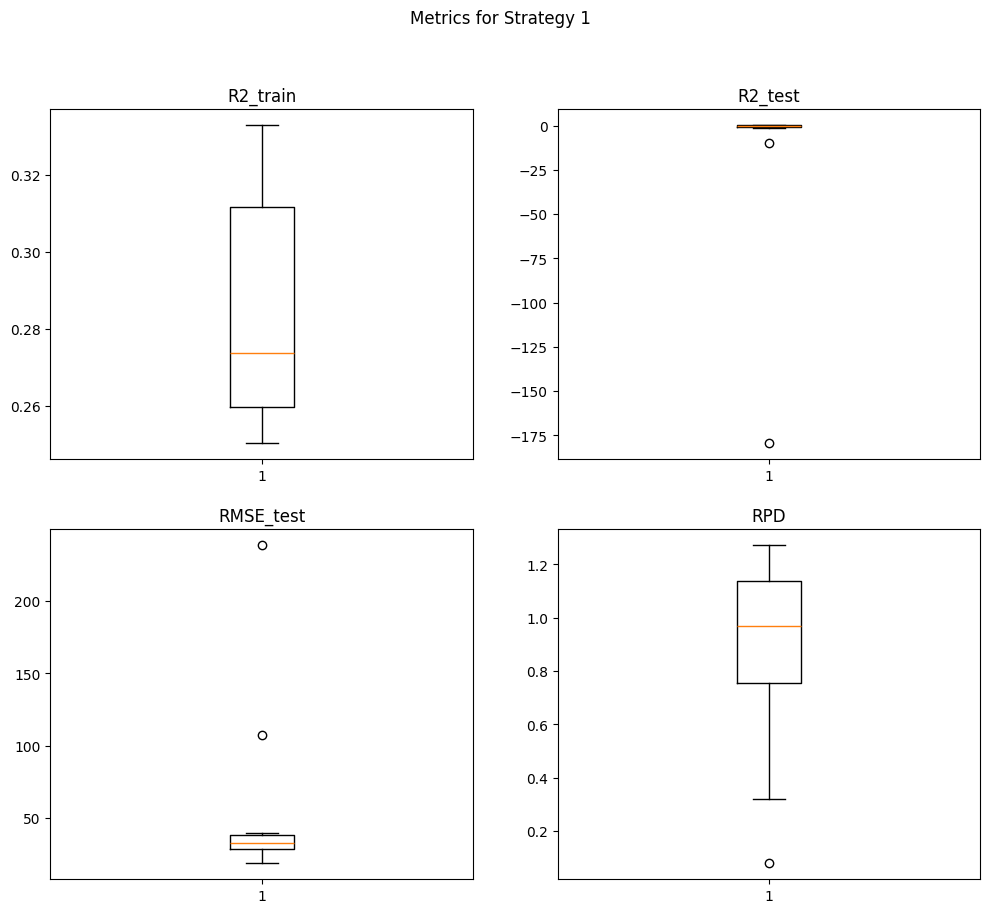

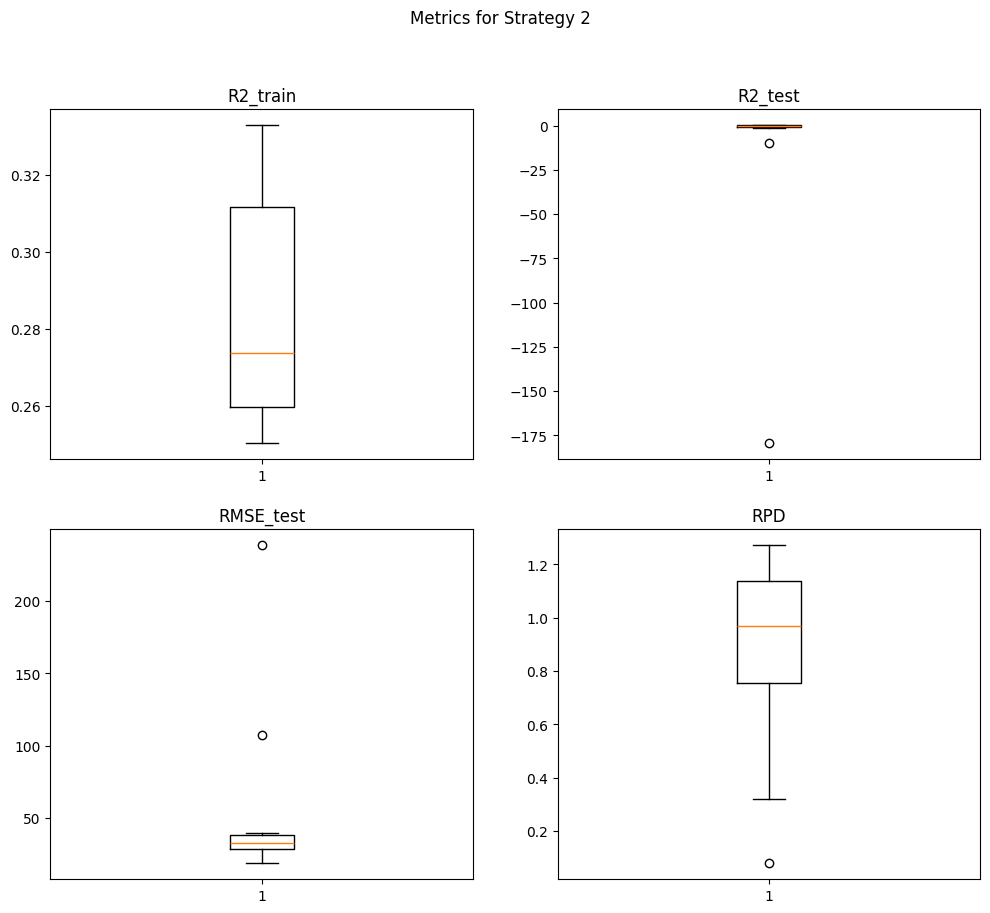

In [27]:
# Plotting the results
for key, metrics in zip(['Strategy 1', 'Strategy 2'], [metrics_strategy_1, metrics_strategy_2]):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Metrics for {key}')

    axs[0, 0].boxplot(metrics['R2_train'])
    axs[0, 0].set_title('R2_train')

    axs[0, 1].boxplot(metrics['R2_test'])
    axs[0, 1].set_title('R2_test')

    axs[1, 0].boxplot(metrics['RMSE_test'])
    axs[1, 0].set_title('RMSE_test')

    axs[1, 1].boxplot(metrics['RPD'])
    axs[1, 1].set_title('RPD')

    plt.show()


In [28]:
# Once the best variables are identified, the final model can be trained on the entire dataset
best_vars = best_vars_strategy_1  # or best_vars_strategy_2 based on the results
X_final = X[best_vars]
model_final = OLS(y, add_constant(X_final)).fit()

# Predicting Presin values for the entire dataset
data['Predicted_Presin'] = model_final.predict(add_constant(X_final))

# Save the predictions to a new CSV file
data.to_csv('reflectance_data_with_predictions.csv', index=False)

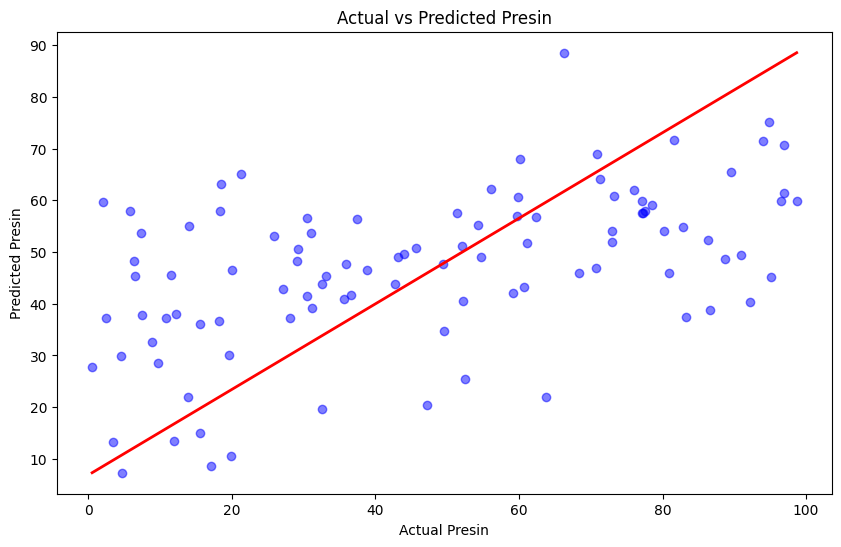

In [30]:
# Plotting actual vs. predicted Presin values
plt.figure(figsize=(10, 6))
plt.scatter(data[Presin_column], data['Predicted_Presin'], color='blue', alpha=0.5)
plt.plot([data[Presin_column].min(), data[Presin_column].max()], 
         [data['Predicted_Presin'].min(), data['Predicted_Presin'].max()], 
         color='red', lw=2)
plt.xlabel('Actual Presin')
plt.ylabel('Predicted Presin')
plt.title('Actual vs Predicted Presin')
plt.show()


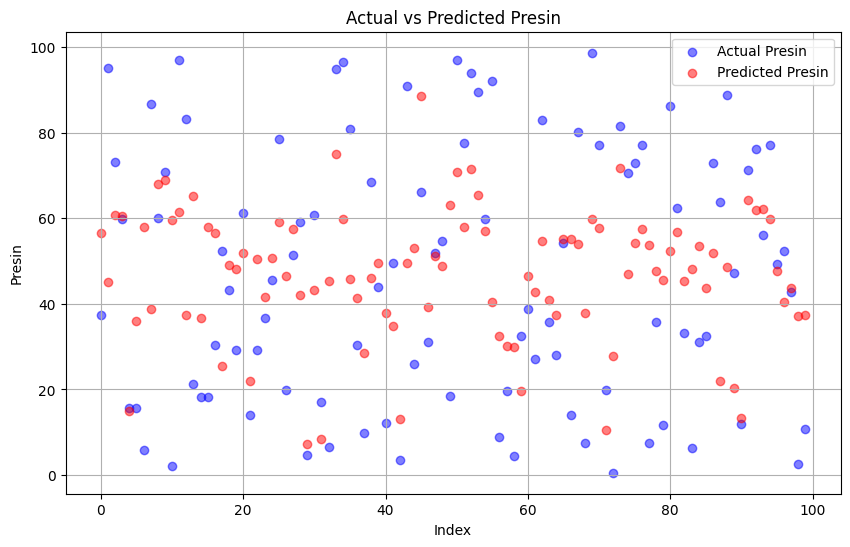

In [31]:
plt.figure(figsize=(10, 6))

# Plotting actual values
plt.scatter(data.index, data[Presin_column], color='blue', alpha=0.5, label='Actual Presin')

# Plotting predicted values
plt.scatter(data.index, data['Predicted_Presin'], color='red', alpha=0.5, label='Predicted Presin')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Presin')
plt.title('Actual vs Predicted Presin')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
#to find accuracy of the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Actual and predicted values
y_actual = data[Presin_column]
y_predicted = data['Predicted_Presin']

# Mean Squared Error
mse = mean_squared_error(y_actual, y_predicted)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_actual, y_predicted)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared
r2 = r2_score(y_actual, y_predicted)
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 640.6406858357899
Root Mean Squared Error (RMSE): 25.310880779534124
Mean Absolute Error (MAE): 20.890975402283186
R-squared (R²): 0.2687998057456782
